In [ ]:
pip install -U matplotlib pandas triton

# 融合 Softmax
在本教程中，您将编写一个融合的 softmax 操作，该操作对于特定类别的矩阵（其行可以放入 GPU 的 SRAM 中）比 PyTorch 的本机操作快得多。
在此过程中，您将了解到：
- 内核融合对于带宽受限操作的好处。
- Triton 中的缩减运算符。

## 动机
用于元素加法的自定义 GPU 核虽然在教学上很有价值，但在实践中却不会有太大帮助。我们来考虑一个简单的（数值稳定的）softmax 运算的情况：

In [ ]:
import torch

import triton
import triton.language as tl
# 从 triton.runtime 中导入 driver，用于查询当前运行环境的硬件信息。
from triton.runtime import driver

# 动态检测并设置当前可用的 GPU 设备。
# 这种方式比硬编码 torch.device("cuda:0") 更具兼容性和鲁棒性。
DEVICE = triton.runtime.driver.active.get_active_torch_device()

# ---
# 整体概览
# 这是一个辅助函数，用于检查 Triton 当前运行的后端是否为 AMD 的 HIP 平台。
# HIP (Heterogeneous-compute Interface for Portability) 是 AMD 提供的、与 CUDA 类似的 GPU 计算平台。
# ---
def is_hip():
    # `triton.runtime.driver.active.get_current_target()` 会获取当前目标硬件和软件平台的信息。
    # `.backend` 属性会返回一个字符串，例如 'cuda' (NVIDIA) 或 'hip' (AMD)。
    # 这行代码通过判断该字符串是否为 "hip" 来确定当前环境。
    return triton.runtime.driver.active.get_current_target().backend == "hip"


# ---
# 整体概览
# 这是一个更具体的辅助函数，用于检查当前的 AMD GPU 是否属于其数据中心级别的 CDNA 架构。
# 这对于某些需要针对特定硬件架构进行优化的场景非常有用。
# ---
def is_cdna():
    # 首先调用 is_hip() 确保当前是 AMD GPU 环境。
    # 然后，获取具体的 GPU 微架构代号（例如 'gfx942'）。
    # 最后，检查这个代号是否存在于已知的 CDNA 架构代号列表中。
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


# ---
# 整体概览
# 这个函数使用原生的 PyTorch 操作，实现了一个“朴素”的行式 Softmax 计算。
# “朴素”指的是它的实现方式是分步的，每个数学步骤都是一次独立的 PyTorch 调用。
# 这种方式虽然直观，但会导致多次对内存（DRAM）的完整读写，性能上不是最优的。
# 函数内部通过减去每行的最大值来防止 `torch.exp` 计算时发生数值溢出，这是一个标准的技巧。
# ---
def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # 第一步：计算每行的最大值，用于后续的数值稳定化处理。
    # `x.max(dim=1)` 会返回一个包含最大值和其索引的元组，[0] 表示我们只取最大值。
    # 内存开销: 读取整个 MN 矩阵；写入一个长度为 M 的临时向量。
    x_max = x.max(dim=1)[0]
    # 第二步：将每行的所有元素都减去该行的最大值。
    # `x_max[:, None]` 将 `x_max` 从 [M] 变形为 [M, 1]，以利用 PyTorch 的广播（Broadcasting）机制进行逐行相减。
    # 内存开销: 读取 MN 矩阵和长度为 M 的最大值向量；写入一个新的 MN 矩阵。
    z = x - x_max[:, None]
    # 第三步：对处理后的矩阵 `z` 的每个元素计算指数。
    # 内存开销: 读取整个 MN 矩阵 `z`；写入一个新的 MN 矩阵。
    numerator = torch.exp(z)
    # 第四步：计算每行指数的总和，作为 Softmax 的分母。
    # 内存开销: 读取整个 MN 指数矩阵；写入一个长度为 M 的总和向量。
    denominator = numerator.sum(dim=1)
    # 第五步：将每行的指数除以该行的总和，得到最终的 Softmax 概率分布。
    # 同样使用 `[:, None]` 技巧进行广播，实现逐行相除。
    # 内存开销: 读取 MN 指数矩阵和长度为 M 的总和向量；写入最终的 MN 结果矩阵。
    ret = numerator / denominator[:, None]
    # 总结：整个过程涉及大量的内存读写，是典型的受内存带宽限制（Memory-Bound）的操作。
    return ret

## 为什么计算 y = naive_softmax(x) - <math xmlns="http://www.w3.org/1998/Math/MathML"><mi>x</mi><mo>&#x2208;</mo><msup><mi>R</mi><mrow data-mjx-texclass="ORD"><mi>M</mi><mo>&#xD7;</mo><mi>N</mi></mrow></msup></math>需要从 DRAM 读取5MN+2M个元素并写回 3MN+2M个元素

### 基本前提

这里的“朴素 (naive)”实现指的是**非融合 (non-fused)** 的实现方式。这意味着 softmax 的每一个数学步骤（求最大值、减去最大值、求指数、求和、相除）都被当作一个独立的计算任务（或者说一个独立的 GPU Kernel）。每一步计算的结果都会被写回至全局内存（DRAM），然后在下一步中再从 DRAM 读取出来。

我们以一个 `[M, N]` 的矩阵 `x` 为例，softmax 是沿着每一行（`N`个元素）独立计算的。

---

### Softmax 的五个计算步骤及内存开销

#### 第一步：计算每行的最大值 (Row-wise Max)

为了进行数值稳定性的优化，我们需要先找到每一行的最大值。
$max_i = \max_{j}(x_{ij})$

* **读取 (Read)**: 为了找到每一行的最大值，我们必须完整地读取一遍整个矩阵 `x`。
    * 读取量: $M \times N$
* **写入 (Write)**: 计算出的每一行的最大值（共 `M` 个）需要被存储在一个临时的向量 `max_vals` 中，以便后续使用。
    * 写入量: $M$

#### 第二步：每行元素减去该行的最大值

$z_{ij} = x_{ij} - max_i$

* **读取 (Read)**:
    1.  需要再次完整地读取一遍原始矩阵 `x`。读取量: $M \times N$
    2.  需要读取上一步计算出的、存有 `M` 个最大值的临时向量 `max_vals`。读取量: $M$
* **写入 (Write)**: 计算结果是一个新的、大小为 `[M, N]` 的中间矩阵 `z`，需要将其写入 DRAM。
    * 写入量: $M \times N$

#### 第三步：计算指数 (Exponentiation)

$exp\_z_{ij} = \exp(z_{ij})$

* **读取 (Read)**: 需要读取上一步生成的整个中间矩阵 `z`。
    * 读取量: $M \times N$
* **写入 (Write)**: 计算结果是一个新的、大小为 `[M, N]` 的中间矩阵 `exp_z`，需要将其写入 DRAM。
    * 写入量: $M \times N$

#### 第四步：计算每行指数的和 (Sum of Exponentials)

$sum_i = \sum_{j} exp\_z_{ij}$

* **读取 (Read)**: 需要读取上一步生成的整个中间矩阵 `exp_z`。
    * 读取量: $M \times N$
* **写入 (Write)**: 计算出的每一行的和（共 `M` 个）需要被存储在一个新的临时向量 `sum_vals` 中。
    * 写入量: $M$

#### 第五步：每行元素除以该行的和 (Division)

$y_{ij} = exp\_z_{ij} / sum_i$

* **读取 (Read)**:
    1.  需要再次读取一遍中间矩阵 `exp_z`。读取量: $M \times N$
    2.  需要读取上一步计算出的、存有 `M` 个和的临时向量 `sum_vals`。读取量: $M$
* **写入 (Write)**: 将最终的计算结果 `y`（也就是 softmax 的输出）写入 DRAM。
    * 写入量: $M \times N$

---

### 汇总计算

现在我们把每一步的读写量加起来。

#### **总读取量 (Total Reads from DRAM)**

* **来自矩阵的读取**:
    * 第一步 (读 `x`): $MN$
    * 第二步 (读 `x`): $MN$
    * 第三步 (读 `z`): $MN$
    * 第四步 (读 `exp_z`): $MN$
    * 第五步 (读 `exp_z`): $MN$
    * 小计: $5 \times MN$
* **来自临时向量的读取**:
    * 第二步 (读 `max_vals`): $M$
    * 第五步 (读 `sum_vals`): $M$
    * 小计: $2 \times M$

**总读取量 = $5MN + 2M$**

#### **总写入量 (Total Writes to DRAM)**

* **写入矩阵**:
    * 第二步 (写 `z`): $MN$
    * 第三步 (写 `exp_z`): $MN$
    * 第五步 (写最终结果 `y`): $MN$
    * 小计: $3 \times MN$
* **写入临时向量**:
    * 第一步 (写 `max_vals`): $M$
    * 第四步 (写 `sum_vals`): $M$
    * 小计: $2 \times M$

**总写入量 = $3MN + 2M$**

### 结论

这个计算结果精确地匹配了题目中的数字。这也突显了“朴素”实现的巨大性能瓶颈：大量的中间结果被反复写入和读出 DRAM。而像 Triton 这样的工具，其核心优势之一就是通过**核函数融合 (Kernel Fusion)**，将这些步骤合并到一个 Kernel 中，使得中间结果（如 `z`, `exp_z`, `max_vals`, `sum_vals`）可以一直保留在 GPU 核心旁边的超高速缓存（SRAM）中，从而极大地减少了对慢速 DRAM 的访问次数，实现性能的大幅提升。

## 计算内核
我们的 softmax 核的工作原理如下：每个程序加载输入矩阵 X 的一组行，其步长为程序数，对其进行规范化，然后将结果写回到输出 Y。
请注意，Triton 的一个重要限制是每个块必须具有 2 的幂数量的元素，因此如果我们想要处理任何可能的输入形状，我们需要在内部“填充”每一行并正确保护内存操作：

In [ ]:
# ---
# 整体概览
# 这是一个为 Softmax 操作量身定制的、高性能的“融合 (Fused)” GPU 核函数。
# 与前面“朴素”的实现方式相比，其核心优势在于“融合”：它将 Softmax 的所有计算步骤
# （找最大值、减法、求指数、求和、除法）合并到了这一个单独的核函数中。
# 这意味着所有的中间计算结果（例如减去最大值后的行、求指数后的行）都一直保留在 GPU 核心
# 旁边的高速缓存（SRAM）中，而不会被写回到慢速的全局内存（DRAM）。
# 这种方式极大地减少了内存读写次数，是 Triton 实现高性能计算的关键所在。
# 此外，这个内核设计得非常灵活，每个程序实例可以处理矩阵中的一行或多行数据。
# ---
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # --- Kernel 参数说明 ---
    # output_ptr, input_ptr: 指向输出和输入张量在 DRAM 中起始位置的指针。
    # input_row_stride, output_row_stride: 步长。表示在内存中从一行开头移动到下一行开头需要跳过的元素数量。
    #   这使得核函数能正确处理非连续的（non-contiguous）张量。
    # n_rows, n_cols: 输入矩阵的行数和列数。
    # BLOCK_SIZE: 编译期常量，其值通常是大于 n_cols 的最小的2的幂。这确保一整行数据可以被一个程序块处理。
    # num_stages: 编译期常量，一个性能调优参数。它用于启用软件流水线（Software Pipelining），
    #   帮助编译器更好地重叠数据加载（内存操作）和计算操作，以隐藏内存访问延迟。

    # --- 并行任务分配 ---
    # `tl.program_id(0)` 获取当前程序实例的唯一ID（沿x轴，即第0轴）。
    # 这决定了当前程序实例开始处理的起始行号。
    row_start = tl.program_id(0)
    # `tl.num_programs(0)` 获取沿x轴启动的程序实例总数。
    # 这个总数成为每个程序实例处理下一行时需要跳过的步长（Grid-Stride Loop）。
    # 例如，如果有8个程序实例，则0号实例处理第0, 8, 16...行。
    row_step = tl.num_programs(0)

    # --- 主循环：遍历分配给当前程序实例的每一行 ---
    # `tl.range` 是一个可由 Triton 优化的循环结构。
    # 这个循环从 `row_start` 开始，以 `row_step` 为步长，遍历所有需要当前实例处理的行 `row_idx`。
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # --- 数据加载 ---
        # 计算当前处理行 `row_idx` 的起始元素在 DRAM 中的地址。
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # 创建一个列偏移的向量，即 [0, 1, 2, ..., BLOCK_SIZE-1]。
        col_offsets = tl.arange(0, BLOCK_SIZE)
        # 将行的起始地址和列偏移相加，得到这一行所有元素的指针向量。
        input_ptrs = row_start_ptr + col_offsets
        # 创建一个掩码（mask），防止访问越界内存。因为 BLOCK_SIZE 可能大于实际的列数 n_cols。
        mask = col_offsets < n_cols
        # 从 DRAM 加载一整行数据到 SRAM 中。
        # `mask=mask`: 只加载掩码为 True 的有效元素。
        # `other=-float('inf')`: 对于掩码为 False 的无效位置，用负无穷大填充。
        # 这是一个巧妙的技巧，因为 `exp(-inf)` 为 0，这些无效值在后续计算中不会影响结果。
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        
        # --- 核心计算（在 SRAM 中完成）---
        # 下面的所有计算都在高速的 SRAM 中进行，没有中间结果写回 DRAM。
        # 1. 减去最大值以保证数值稳定性。
        row_minus_max = row - tl.max(row, axis=0)
        # 2. 计算分子（求指数）。Triton 的 `exp` 速度快但可能是近似计算。
        numerator = tl.exp(row_minus_max)
        # 3. 计算分母（求和）。
        denominator = tl.sum(numerator, axis=0)
        # 4. 计算最终的 Softmax 输出。
        softmax_output = numerator / denominator
        
        # --- 数据写回 ---
        # 计算当前处理行在输出张量中的起始地址。
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        # 计算输出张量中这一行所有元素的指针向量。
        output_ptrs = output_row_start_ptr + col_offsets
        # 将计算好的 `softmax_output` 向量从 SRAM 写回到 DRAM。
        # 同样使用掩码，确保只写入有效的位置。
        tl.store(output_ptrs, softmax_output, mask=mask)

我们可以创建一个辅助函数，将内核及其（元）参数排入任何给定输入张量的队列。

In [ ]:
# --- GPU 设备属性查询 ---
# 在定义主函数之前，首先查询并存储当前激活的 GPU 设备的一系列硬件属性。
# 这些属性对于后续进行性能优化，特别是计算理论占用率（Occupancy）至关重要。
properties = driver.active.utils.get_device_properties(DEVICE.index)
# NUM_SM: GPU 上的流式多处理器（Streaming Multiprocessor, SM）或计算单元（Compute Unit, CU）的数量。这是GPU的核心计算单元。
NUM_SM = properties["multiprocessor_count"]
# NUM_REGS: 每个 SM 可用的最大寄存器数量。
NUM_REGS = properties["max_num_regs"]
# SIZE_SMEM: 每个 SM 可用的最大共享内存（Shared Memory）容量，单位是字节。
SIZE_SMEM = properties["max_shared_mem"]
# WARP_SIZE: 一个 Warp 或 Wave 中包含的线程数量（在NVIDIA和AMD上通常是32）。这是GPU调度的基本单位。
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

# ---
# 整体概览
# 这是一个经过高度优化的 "主机端 (host-side)" Softmax 发射器函数。
# 它的核心思想不再是为矩阵的每一行都启动一个单独的核函数实例，因为当行数很多时，这会带来巨大的启动开销。
# 相反，它采用了一种更先进的策略：
# 1. 预编译（Warmup）：先编译核函数，以获取其对硬件资源（寄存器、共享内存）的实际需求。
# 2. 计算占用率（Occupancy）：根据核函数的资源需求和GPU的硬件限制，计算出理论上能让GPU达到最大吞吐量的、最优的并行程序数量。
# 3. 启动持久化内核（Persistent Kernel）：启动计算出的最优数量的、常驻的程序实例。每个实例都会在内部循环，不断地处理矩阵中的多行数据，直到所有行被处理完毕。
# 这种方法通过最大化硬件利用率和最小化启动开销，来达到极致的性能。
# ---
def softmax(x):
    n_rows, n_cols = x.shape

    # 确定每个程序块（Block）的大小。这里使用 `triton.next_power_of_2` 函数，
    # 找到大于列数 `n_cols` 的最小的2的幂。使用2的幂作为块大小通常能让编译器进行更高效的地址计算和优化。
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # 这是一个性能调优启发式（heuristic）参数。通过增加每个程序块中 Warp 的数量，
    # 可以让更多的线程协作处理一行数据，这对于非常宽的行（n_cols很大）可能带来性能提升。
    num_warps = 8

    # 软件流水线（Software Pipelining）的阶段数。这也是一个启发式设置：
    # 如果GPU的共享内存（SIZE_SMEM）较大，就使用更多的阶段（4），这有助于更好地隐藏数据加载延迟；否则使用较少的阶段（2）。
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # 预分配用于存储结果的输出张量。
    y = torch.empty_like(x)

    # --- 预编译内核并获取资源使用情况 ---
    # `softmax_kernel.warmup` 是一个特殊调用，它会为给定的参数和硬件 JIT-编译 内核，但不会真正执行。
    # 它的主要目的是让我们能够提前探知编译后的内核信息。
    # `grid=(1, )` 表示我们只是为了编译，用一个虚拟的网格尺寸即可。
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    # 获取编译后的内核实际使用的资源量：
    # n_regs: 每个线程需要的寄存器数量。
    # size_smem: 每个程序块（Block）需要的共享内存大小。
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    
    # --- 核心：计算理论占用率 (Occupancy) 和最优程序数 ---
    # 占用率指一个 SM 上同时活跃的 Warp/Wave 数量与硬件所能支持的最大数量的比例。
    # 我们需要分别计算受寄存器限制的占用率和受共享内存限制的占用率，然后取其中的较小值。
    if is_hip():
        # --- AMD (HIP) 平台的占用率计算 ---
        # 在 AMD CDNA 架构上，物理寄存器分为通用寄存器（VGPR）和累加寄存器（AGPR），总数可能更多。
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # `max_threads_per_sm` 是硬件限制的一个SM上能同时驻留的总线程数。
        # 除以 `WARP_SIZE` 就得到了硬件支持的最大并发 Wave 数量。
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        # 受寄存器限制，一个 SM 能容纳的 Wave 数量 = 总寄存器数 / (每个线程的寄存器数 * 每Wave的线程数)。
        # 我们取这个值和硬件最大值中较小的一个，然后除以我们自己设定的 `num_warps`，得到一个 SM 能容纳多少个我们的“程序”。
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        # --- NVIDIA (CUDA) 平台的占用率计算 ---
        # 计算逻辑更直接：一个SM能容纳的“程序”数 = 总寄存器数 / (一个程序需要的总寄存器数)。
        # 一个程序需要的总寄存器数 = n_regs * WARP_SIZE * num_warps。
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    
    # 一个 SM 能容纳的程序数还受共享内存的限制，所以要取两者的最小值。
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    
    # 最佳的程序总数 = 每个 SM 能运行的程序数 * SM 的总数。
    # 这旨在启动恰好足够的程序来“喂饱”整个 GPU。
    num_programs = NUM_SM * occupancy
    
    # 启动的程序总数不应该超过需要处理的总行数。
    num_programs = min(num_programs, n_rows)

    # --- 启动持久化内核 ---
    # 使用计算出的 `num_programs` 作为网格大小来启动内核。
    # 这会创建 `num_programs` 个持久化的程序实例，每个实例都会在内部循环处理多行数据。
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

## 单元测试
我们确保在行数和列数不规则的矩阵上测试我们的核函数。这将使我们能够验证填充机制是否有效。

In [ ]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

## 基准
这里，我们将根据输入矩阵的列数（假设为 4096 行）对我们的操作进行基准测试。然后，我们将它的性能与 (1)`torch.softmax` 和 (2) 上面定义的 `naive_softmax` 进行比较。

In [ ]:
# `@triton.testing.perf_report` 装饰器驱动整个基准测试流程。
@triton.testing.perf_report(
    # `triton.testing.Benchmark` 类用于配置实验的各个参数。
    triton.testing.Benchmark(
        # x_names: 定义图表 x 轴为矩阵的列数 `N`。
        x_names=['N'],
        # x_vals: x 轴上 `N` 的一系列具体取值。
        x_vals=[128 * i for i in range(2, 100)],
        # line_arg: 定义用于区分不同曲线的参数为 `provider`。
        line_arg='provider',
        # line_vals: `provider` 参数的具体取值。这次我们有三个对比项。
        line_vals=['triton', 'torch', 'naive_softmax'],
        # line_names: 图例中每条曲线的显示名称，与 `line_vals` 一一对应。
        line_names=[
            "Triton", "Torch", "Naive Softmax"],
        # styles: 为三条曲线分别定义视觉样式。
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],
        # ylabel: y 轴的标签为内存带宽（GB/s）。
        ylabel="GB/s",
        # plot_name: 图表的标题和保存时的文件名。
        plot_name="softmax-performance",
        # args: 将矩阵行数 `M` 固定为 4096。
        args={'M': 4096},
    ))
# 基准测试的核心执行函数。装饰器会用 `N` 和 `provider` 的不同组合来调用它。
def benchmark(M, N, provider):
    # 创建随机的输入张量。
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    # 创建并设置一个独立的 CUDA/HIP Stream，以确保测试环境的纯净。
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    
    # 根据 `provider` 的值，选择要进行基准测试的函数。
    if provider == 'torch':
        # 测试 PyTorch 官方的高度优化的 `softmax` 函数。
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        # 测试我们自己编写的、经过优化的 `softmax` 融合内核。
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        # 新增的测试分支：测试分步实现的 `naive_softmax` 函数。
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
        
    # 定义一个 lambda 函数，用于将测得的时间（毫秒）转换为有效内存带宽（GB/s）。
    # 计算公式基于理想情况下的内存访问量：一次输入读取和一次输出写入。
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    # 返回计算出的中位数带宽值。
    return gbps(ms)


# --- 执行基准测试 ---
# 调用 `.run()` 方法来启动整个基准测试流程。
# `show_plots=True`: 测试完成后会自动显示生成的性能对比图。
# `print_data=True`: 会在控制台打印出详细的性能数据表。
benchmark.run(show_plots=True, print_data=True)

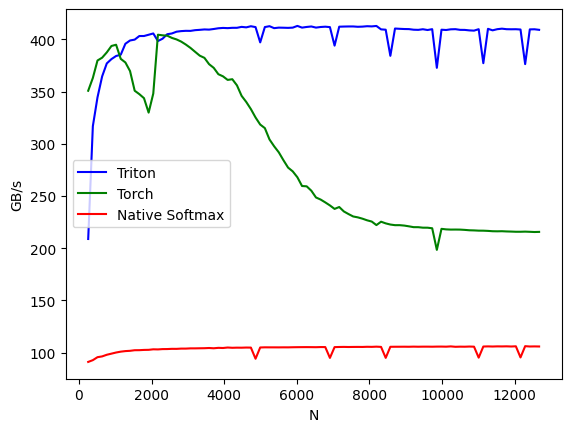

在上图中，我们可以看到：
- Triton 比 Torch JIT 快 4 倍。这证实了我们的猜测，即 Torch JIT 在这里没有进行任何融合。
- Triton 的速度明显比 `torch.softmax` 快，而且更易于阅读、理解和维护 。但请注意，PyTorch 的 softmax 运算更通用，可以处理任何形状的张量。